In [1]:
import sys
sys.path.append('/home/miguelcosta/Desktop/PBL-HGO')
import pandas as pd
# import pandasql as ps
#import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from src.db.connection import *
from src.modelling_pipelines.final_model_pipeline import *
from src.modelling_pipelines.modelling_functions.xgboost import *
alertP1=connection("credentials.txt")
data = pre_process(alertP1)

X = data.Texto
y = data.result # Target variable

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16,shuffle=False)


Tables: [(bytearray(b'ConsultaUrgencia_doentespedidosconsultaNeurologia2012'),), (bytearray(b'consultaneurologia2012'),), (bytearray(b'consultaneurologia201216anon_true'),), (bytearray(b'hgo_data_032023'),)]
521


/home/miguelcosta/Desktop/PBL-HGO/src/db/connection.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  alertP1 = pd.read_sql("""SELECT * FROM consultaneurologia201216anon_true""",mydb)
/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
/home/miguelcosta/Desktop/PBL-HGO/src/pre_processing/data_cleaning.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
import torch

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            padding='max_length',
            max_length=512,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def train_model(X_train, y_train, model_name, learning_rate, weight_decay=1e-3, dropout_rate=0.5, optimizer_name="Adam", num_epochs=1):
    # Convert Series to lists
    X_train = X_train.tolist()
    y_train = y_train.tolist()

    # Load model and tokenizer
    model = AutoModelForSequenceClassification.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Add dropout layers to the model
    model.config.hidden_dropout_prob = dropout_rate
    model.config.attention_probs_dropout_prob = dropout_rate

    # Convert data to tensors
    dataset = TextDataset(X_train, y_train, tokenizer)
    dataloader = DataLoader(dataset, batch_size=64)

    # Define optimizer using the sampled learning_rate and weight_decay
    if optimizer_name == "Adam":
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "SGD":
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_name == "RMSProp":
        optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    else:
        raise ValueError("Unknown optimizer: " + optimizer_name)

    # Define loss function
    loss_fn = CrossEntropyLoss()

    # Training loop
    for epoch in range(num_epochs):  # Number of epochs
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']
            labels = batch['labels']

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Compute loss
            loss = loss_fn(logits.view(-1, model.config.num_labels), labels.view(-1))

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    return model


def predict(model, X_test, model_name):
    # Convert Series to list
    X_test = X_test.tolist()

    # Load tokenizer
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    # Convert data to tensors
    dataset = TextDataset(X_test, [0]*len(X_test), tokenizer)  # Dummy labels for prediction
    dataloader = DataLoader(dataset, batch_size=64)

    predictions = []

    # Prediction loop
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids']
            attention_mask = batch['attention_mask']

            # Forward pass
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Get predictions
            _, preds = torch.max(logits.view(-1, model.config.num_labels), dim=1)
            predictions.extend(preds.tolist())

    return predictions


/home/miguelcosta/.conda/envs/aequitas/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import optuna
from sklearn.metrics import f1_score

# Define the objective function using F1 score
def objective(trial):
    # Sample hyperparameters
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
    #num_epochs = trial.suggest_int("num_epochs", 3, 10)
    #weight_decay = trial.suggest_loguniform("weight_decay", 1e-6, 1e-3)
    #dropout_rate = trial.suggest_uniform("dropout_rate", 0.0, 0.5)
    #optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "SGD", "RMSProp"])
    
    # Train and evaluate a model using the sampled hyperparameters
    #model = train_model(X_train, y_train, model_name, learning_rate, weight_decay, dropout_rate, optimizer_name, num_epochs)
    model = train_model(X_train, y_train, model_name, learning_rate)

    predictions = predict(model, X_test, model_name)
    
    # Calculate F1 score
    f1 = f1_score(y_test, predictions)

    return f1

# Create an Optuna study
#study = optuna.create_study(direction="maximize")  # Note the direction "maximize" for F1 score

# Start the optimization process
#study.optimize(objective, n_trials=50)  # You can adjust the number of trials

# Access the best hyperparameters
#best_params = study.best_params

# Train the final model with the best hyperparameters
#final_model = train_model(X_train, y_train, model_name, **best_params)

# Evaluate the final model on the test set
#test_predictions = predict(final_model, X_test, model_name)
#test_f1 = f1_score(y_test, test_predictions)


In [1]:
import torch

print(torch.__version__)



2.1.0


In [5]:
model_name = "pucpr/biobertpt-all"

# Create an Optuna study
study = optuna.create_study(direction="maximize")  # Note the direction "maximize" for F1 score

# Start the optimization process
study.optimize(objective, n_trials=1)  # You can adjust the number of trials

# Access the best hyperparameters
best_params = study.best_params

[I 2023-10-13 17:44:59,801] A new study created in memory with name: no-name-ecc74221-e6a9-462f-b7b0-4e1ae9da2f5d
/tmp/ipykernel_385016/1110449813.py:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pucpr/biobertpt-all and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/miguelcosta/.conda/envs/aequitas/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_depre

In [6]:
# Train the final model with the best hyperparameters
final_model = train_model(X_train, y_train, model_name, **best_params)

# Evaluate the final model on the test set
test_predictions = predict(final_model, X_test, model_name)
test_f1 = f1_score(y_test, test_predictions)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at pucpr/biobertpt-all and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/miguelcosta/.conda/envs/aequitas/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [7]:
test_f1

0.7917448405253283

/tmp/ipykernel_385016/3358216001.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=test_predictions, palette='Set2')


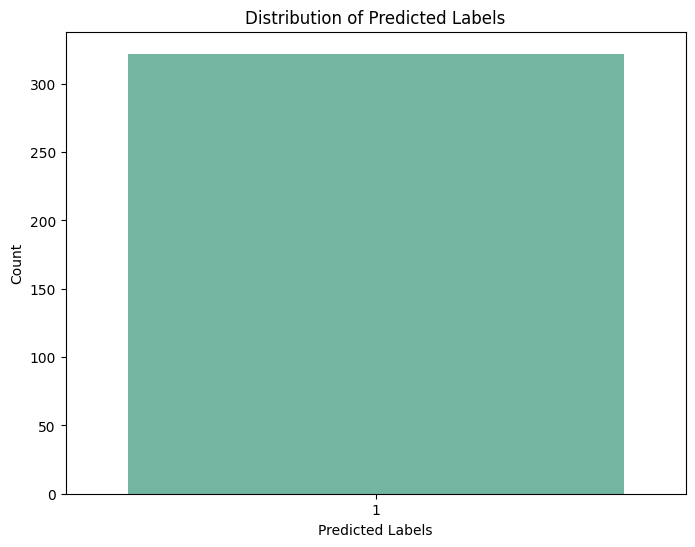

In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

# Create a count plot
plt.figure(figsize=(8, 6))
sns.countplot(x=test_predictions, palette='Set2')
plt.xlabel('Predicted Labels')
plt.ylabel('Count')
plt.title('Distribution of Predicted Labels')
plt.show()